# President Trump's 2020 Rally Speeches

In [1]:
import numpy as np 
import pandas as pd 
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly
plotly.offline.init_notebook_mode (connected = True)
import seaborn as sns
sns.set_style('darkgrid')
import nltk
from wordcloud import WordCloud,STOPWORDS
import string
import re
import spacy as sp
nlps = sp.load('en')

## Data Loading

In [19]:
trump = pd.read_csv("trump_rally_transcripts.csv")
trump = trump.drop('Unnamed: 0', axis=1)
t_loc_date = pd.read_excel("trump_speech_date_location.xlsx")

In [56]:
trump_speeches2 = trump.merge(t_loc_date,how='left',on='title')

array(['NC', 'OH', 'NH', 'NM', 'TX', 'MN', 'MS', 'KY', 'PA', 'MI', 'WI',
       'NJ', nan, 'AZ', 'CO', 'NV', 'SC', 'OK', 'FL', 'VA', 'DC', 'IA',
       'GA', 'NE'], dtype=object)

In [28]:
trump_speeches.head()

,url,title,transcript,year,month,day,state,city/county,city/county type,note
0,https://www.rev.com/blog/transcripts/donald-tr...,"Donald Trump Speech Transcript at Greenville, ...",\nThank you very much. Thank you. Thank you. ...,2019.0,7.0,17.0,NC,Greensville,red,NaN
1,https://www.rev.com/blog/transcripts/donald-tr...,Donald Trump Cincinnati Rally Speech Transcrip...,\nThank you all. Thank you very much. Thank y...,2019.0,8.0,1.0,OH,Cincinnati,blue,NaN
2,https://www.rev.com/blog/transcripts/donald-tr...,Donald Trump New Hampshire Rally Transcript Au...,\nThank you very much everybody. Thank you. W...,2019.0,8.0,15.0,NH,Manchester,blue,NaN
3,https://www.rev.com/blog/transcripts/donald-tr...,Donald Trump North Carolina Rally Transcript i...,"\nHello North Carolina! \nTo Senator Tillis, ...",2019.0,9.0,9.0,NC,Fayetteville,blue,NaN
4,https://www.rev.com/blog/transcripts/donald-tr...,Donald Trump New Mexico Rally Transcript: Full...,"\nThank you. \nWow, thank you. Thank you, New...",2019.0,9.0,16.0,NM,Rio Rancho,blue,NaN


## Feature Engineering 

In [29]:
# group states by color
swing_states = ['GA','NC','AZ','FL','IA','MI','NV','NH','OH','PA','TX','WI']
blue = ['WA','OR','CA','CO','NM','HI','MN','IL','ME','NY','VA','VT','MA','RI',
       'CT','NJ','DE','MD','DC']

trump_speeches['state type'] = 'red state'
trump_speeches.loc[trump_speeches['state'].isin(swing_states),'state type']='swing state'
trump_speeches.loc[trump_speeches['state'].isin(blue),'state type']='blue state'


In [30]:
trump_speeches['state result'] = trump_speeches['state type']
trump_speeches.loc[trump_speeches['state'].isin(['GA','PA', 'AZ', 'MI','NV','NH','WI']) ,'state result'] = 'swing-blue'
trump_speeches.loc[trump_speeches['state result'] =='swing state' ,'state result'] = 'swing-red'
trump_speeches['state result'].value_counts()

swing-blue    43
swing-red     24
blue state     9
red state      7
Name: state result, dtype: int64

In [31]:
from nltk.tokenize import RegexpTokenizer, sent_tokenize


trump_speeches['transcript'] = trump_speeches['transcript'].str.strip()

#sentences of words in each speech
word_tokenizer = RegexpTokenizer(r'\w+')
trump_speeches['word_tokens'] = trump_speeches['transcript'].apply(lambda x: word_tokenizer.tokenize(x))
trump_speeches['# of words'] = trump_speeches['word_tokens'].apply(lambda x: len(x))

#sentences in sentences in each speech

trump_speeches['sentence_tokens'] = trump_speeches['transcript'].apply(lambda x: sent_tokenize(x))
trump_speeches['# of sentences'] = trump_speeches['sentence_tokens'].apply(lambda x: len(x))
trump_speeches['Average Sentence Length'] = trump_speeches['sentence_tokens'].apply(lambda x: np.mean(np.array([len(word_tokenizer.tokenize(s)) for s in x])))



In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

trump_speeches['sentiment'] = trump_speeches['transcript'].apply(lambda x: analyzer.polarity_scores(x))
trump_speeches['positive sentiment'] =trump_speeches['sentiment'].apply(lambda x: x['pos']) 
trump_speeches['neutral sentiment'] =trump_speeches['sentiment'].apply(lambda x: x['neu']) 
trump_speeches['negative sentiment'] =trump_speeches['sentiment'].apply(lambda x: x['neg'])
trump_speeches['overall sentiment'] =trump_speeches['sentiment'].apply(lambda x: x['compound'])
trump_speeches.drop(columns=['sentiment'],inplace=True)


In [202]:
from nrclex import NRCLex
trump_speeches['nrc'] = trump_speeches['transcript'].apply(lambda x: NRCLex(x))

In [203]:
trump_speeches['fear'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['fear'])
trump_speeches['anger'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['anger'])
trump_speeches['anticipation'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['anticipation'])
trump_speeches['trust'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['trust'])
trump_speeches['surprise'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['surprise'])
trump_speeches['positive'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['positive'])
trump_speeches['negative'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['negative'])
trump_speeches['sadness'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['sadness'])
trump_speeches['disgust'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['disgust'])
trump_speeches['joy'] = trump_speeches['nrc'].apply(lambda x: x.affect_frequencies['joy'])

In [205]:
trump_speeches['top emotions'] = trump_speeches['nrc'].apply(lambda x: x.top_emotions)

In [220]:
trump_speeches['top emotions'].str[0].str[0].value_counts()

positive    83
Name: top emotions, dtype: int64

In [37]:
trump_speeches.to_csv("trump_speeches_v4.csv")

In [58]:
trump_speeches= pd.read_csv("trump_speeches_v4.csv")
len(trump_speeches)

83

## EDA

### Speech by Location

In [193]:
trump_speeches['state'].nunique()

23

In [197]:
trump_speeches['city/county'].nunique()

77

In [98]:
trump_speeches['state result'].value_counts() #goodness of fit -> significant.

swing-blue    43
swing-red     24
blue state     9
red state      7
Name: state result, dtype: int64

In [99]:
trump_speeches['city/county type'].value_counts() 

blue    49
red     34
Name: city/county type, dtype: int64

In [62]:
trump_speeches.groupby(['state type','city/county type'])['transcript'].count()

state type   city/county type
blue state   blue                 6
             red                  3
red state    blue                 4
             red                  3
swing state  blue                39
             red                 28
Name: transcript, dtype: int64

In [65]:
trump_speeches.groupby(['state result','city/county type'])['transcript'].count()

state result  city/county type
blue state    blue                 6
              red                  3
red state     blue                 4
              red                  3
swing-blue    blue                24
              red                 19
swing-red     blue                15
              red                  9
Name: transcript, dtype: int64

### Length

#### Average number of sentences

In [72]:
from scipy.stats import kurtosis 
trump_speeches['# of sentences'].groupby(trump_speeches['state result']).apply(kurtosis)

state result
blue state   -0.157022
red state    -0.216261
swing-blue   -0.450389
swing-red     1.516924
Name: # of sentences, dtype: float64

In [73]:
trump_speeches['# of sentences'].groupby(trump_speeches['state result']).median() #kruskal.test -> not significant

state result
blue state    1012
red state     1057
swing-blue    1033
swing-red      967
Name: # of sentences, dtype: int64

In [76]:
trump_speeches['# of sentences'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).apply(kurtosis)

state result  city/county type
blue state    blue               -1.575992
              red                -1.500000
red state     blue               -1.236670
              red                -1.500000
swing-blue    blue               -0.821833
              red                -0.328164
swing-red     blue                1.261254
              red                 0.499422
Name: # of sentences, dtype: float64

In [77]:
trump_speeches['# of sentences'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).median()

state result  city/county type
blue state    blue                 888.5
              red                 1195.0
red state     blue                 969.0
              red                 1118.0
swing-blue    blue                1008.0
              red                 1072.0
swing-red     blue                 948.0
              red                  972.0
Name: # of sentences, dtype: float64

In [221]:
trump_speeches['# of sentences'].groupby(trump_speeches['city/county type']).mean()


city/county type
blue     995.877551
red     1081.970588
Name: # of sentences, dtype: float64

#### Average number of words

In [297]:
trump_speeches['# of words'].groupby(trump_speeches['state result']).median()#kruskal.test -> not significant

state result
blue state    11909
red state     10404
swing-blue    10695
swing-red     11168
Name: # of words, dtype: int64

In [298]:
trump_speeches['# of words'].groupby([trump_speeches['state type'],trump_speeches['city/county type'] ]).median()

state type   city/county type
blue state   blue                 9771.0
             red                 12725.0
red state    blue                 9382.0
             red                 11884.5
swing state  blue                10857.0
             red                 10714.0
Name: # of words, dtype: float64

In [222]:
trump_speeches['# of words'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).median()

state result  city/county type
blue state    blue                 9771
              red                 12725
red state     blue                 9893
              red                 13351
swing-blue    blue                10776
              red                 10635
swing-red     blue                11140
              red                 11196
Name: # of words, dtype: int64

In [223]:
trump_speeches['# of words'].groupby(trump_speeches['city/county type']).mean()


city/county type
blue    10722.591837
red     11542.735294
Name: # of words, dtype: float64

#### Average sentence length

In [226]:
trump_speeches['Average Sentence Length'].groupby(trump_speeches['state result']).median() #kruskal.test -> not significant

state result
blue state    11.188679
red state     10.943277
swing-blue    10.328016
swing-red     10.818677
Name: Average Sentence Length, dtype: float64

In [227]:
trump_speeches['Average Sentence Length'].groupby(trump_speeches['city/county type']).median() #kruskal.test -> not significant

city/county type
blue    10.565531
red     10.584756
Name: Average Sentence Length, dtype: float64

In [302]:
trump_speeches['Average Sentence Length'].groupby([trump_speeches['state type'],trump_speeches['city/county type'] ]).median()

state type   city/county type
blue state   blue                11.349320
             red                 10.648536
red state    blue                10.417460
             red                 11.442569
swing state  blue                10.553678
             red                 10.493728
Name: Average Sentence Length, dtype: float64

In [224]:
trump_speeches['Average Sentence Length'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).median()

state result  city/county type
blue state    blue                11.349320
              red                 10.648536
red state     blue                10.533361
              red                 11.941860
swing-blue    blue                10.305623
              red                 10.453505
swing-red     blue                10.960957
              red                 10.533951
Name: Average Sentence Length, dtype: float64

In [225]:
trump_speeches['Average Sentence Length'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).apply(kurtosis)

state result  city/county type
blue state    blue               -1.452798
              red                -1.500000
red state     blue               -1.114303
              red                -1.500000
swing-blue    blue                1.381459
              red                -0.668184
swing-red     blue               -0.258068
              red                 1.610850
Name: Average Sentence Length, dtype: float64

## Emotion Analysis

In [92]:
trump_speeches.groupby(['state result'])[['fear','anger','anticipation','trust','surprise','positive','negative','sadness','disgust','joy']].median()

,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
state result,,,,,,,,,,
blue state,0.079188,0.077225,0.095533,0.148044,0.052356,0.202035,0.135174,0.074074,0.049084,0.084767
red state,0.083297,0.079924,0.095056,0.138974,0.053273,0.191984,0.140992,0.079169,0.052944,0.080303
swing-blue,0.081278,0.076350,0.096215,0.146322,0.054226,0.201496,0.134529,0.076350,0.044654,0.085040
swing-red,0.080593,0.076117,0.103731,0.146241,0.053419,0.206005,0.132469,0.073825,0.045534,0.085197


In [93]:
trump_speeches.groupby(['city/county type'])[['fear','anger','anticipation','trust','surprise','positive','negative','sadness','disgust','joy']].median()

,fear,anger,anticipation,trust,surprise,positive,negative,sadness,disgust,joy
city/county type,,,,,,,,,,
blue,0.081081,0.076799,0.096832,0.145415,0.052775,0.199235,0.135080,0.074524,0.047237,0.082364
red,0.081643,0.076310,0.097132,0.146445,0.054290,0.202539,0.133794,0.076236,0.044923,0.085917


In [319]:
trump_speeches.groupby([trump_speeches['state result'],trump_speeches['city/county type'] ])[['fear','anger','anticipation','trust','surprise','positive','negative','sadness','disgust','joy']].median()

fear     anger  anticipation     trust  \
state result city/county type                                               
blue state   blue              0.080135  0.077310      0.095655  0.147181   
             red               0.078991  0.073934      0.095533  0.149899   
red state    blue              0.083622  0.078474      0.099956  0.139535   
             red               0.082949  0.080164      0.088215  0.139916   
swing-blue   blue              0.081288  0.075738      0.093941  0.146853   
             red               0.080605  0.077198      0.096394  0.145917   
swing-red    blue              0.080703  0.077343      0.097910  0.145415   
             red               0.080483  0.073834      0.104679  0.146973   

                               surprise  positive  negative   sadness  \
state result city/county type                                           
blue state   blue              0.050645  0.199344  0.138840  0.077735   
             red               0.052936  0.208466  0.133168  0.072195   
red state    blue              0.056903  0.191984  0.137061  0.079169   
             red               0.051441  0.194926  0.144138  0.076900   
swing-blue   blue              0.052806  0.199870  0.134553  0.075379   
             red               0.056003  0.201636  0.134420  0.077208   
swing-red    blue              0.053935  0.200397  0.133441  0.074502   
             red               0.052903  0.206464  0.128270  0.073324   

                                disgust       joy  
state result city/county type                      
blue state   blue              0.045860  0.082664  
             red               0.049214  0.086692  
red state    blue              0.052944  0.079790  
             red               0.055661  0.085691  
swing-blue   blue              0.045029  0.083914  
             red               0.043199  0.085106  
swing-red    blue              0.047761  0.083097  
             red               0.041016  0.089395

## Entity Recognition


- Biden


In [83]:
import re
trump_speeches['mention biden']= trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('joe biden|joe|biden', x)).str.len()


In [153]:
trump_speeches.groupby(['state result'])['mention biden'].mean()

state result
blue state    19.333333
red state     27.714286
swing-blue    38.790698
swing-red     29.791667
Name: mention biden, dtype: float64

In [154]:
trump_speeches.groupby(['city/county type'])['mention biden'].mean() #graph

city/county type
blue    29.265306
red     38.735294
Name: mention biden, dtype: float64

In [155]:
trump_speeches['mention biden'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()

state result  city/county type
blue state    blue                16.833333
              red                 24.333333
red state     blue                18.000000
              red                 40.666667
swing-blue    blue                35.666667
              red                 42.736842
swing-red     blue                27.000000
              red                 34.444444
Name: mention biden, dtype: float64

- trump

In [115]:
trump_speeches['mention trump']= trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('trump', x)).str.len()

In [156]:
trump_speeches.groupby(['state result'])['mention trump'].mean()

state result
blue state    16.111111
red state     10.428571
swing-blue    13.116279
swing-red     11.083333
Name: mention trump, dtype: float64

In [157]:
trump_speeches.groupby(['city/county type'])['mention trump'].mean()

city/county type
blue    11.734694
red     13.911765
Name: mention trump, dtype: float64

In [158]:
trump_speeches['mention trump'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()

state result  city/county type
blue state    blue                13.333333
              red                 21.666667
red state     blue                12.500000
              red                  7.666667
swing-blue    blue                11.916667
              red                 14.631579
swing-red     blue                10.600000
              red                 11.888889
Name: mention trump, dtype: float64

- immigration

In [352]:
trump_speeches['mention immigration']= trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('immigration|immigrant|wall|border|illegal|alien', x)).str.len()


In [353]:
trump_speeches.groupby(['state result'])['mention immigration'].mean()

state result
blue state    22.222222
red state     31.142857
swing-blue    24.906977
swing-red     23.500000
Name: mention immigration, dtype: float64

In [303]:
trump_speeches.groupby(['city/county type'])['mention immigration'].mean()

city/county type
blue    24.163265
red     19.705882
Name: mention immigration, dtype: float64

In [164]:
trump_speeches['mention immigration'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()

state result  city/county type
blue state    blue                1.333333
              red                 2.000000
red state     blue                3.750000
              red                 1.666667
swing-blue    blue                1.958333
              red                 1.052632
swing-red     blue                2.200000
              red                 2.111111
Name: mention immigration, dtype: float64

- economy

In [373]:
trump_speeches['mention econ'] = trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('economic|economy|oil|trade|company|business|tariff', x)).str.len()


In [355]:
trump_speeches.groupby(['state result'])['mention econ'].mean() #1-way anova

state result
blue state    12.444444
red state     18.285714
swing-blue    23.930233
swing-red     16.500000
Name: mention econ, dtype: float64

In [358]:
trump_speeches.groupby(['city/county type'])['mention econ'].mean()

city/county type
blue    18.653061
red     22.088235
Name: mention econ, dtype: float64

In [360]:
trump_speeches['mention econ'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()

state result  city/county type
blue state    blue                10.500000
              red                 16.333333
red state     blue                15.000000
              red                 22.666667
swing-blue    blue                22.000000
              red                 26.368421
swing-red     blue                17.533333
              red                 14.777778
Name: mention econ, dtype: float64

- minority

In [347]:
trump_speeches['mention minority'] = trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('black|color|indian|hispanic|latino|minority', x)).str.len()

In [348]:
trump_speeches.groupby(['state result'])['mention minority'].median() #1-way anova

state result
blue state    5.0
red state     3.0
swing-blue    6.0
swing-red     5.5
Name: mention minority, dtype: float64

In [349]:
trump_speeches.groupby(['city/county type'])['mention minority'].max()

city/county type
blue    27
red     37
Name: mention minority, dtype: int64

In [362]:
trump_speeches['mention minority'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()

state result  city/county type
blue state    blue                12.333333
              red                 14.333333
red state     blue                 3.750000
              red                  5.333333
swing-blue    blue                 6.083333
              red                  8.157895
swing-red     blue                 5.666667
              red                  5.555556
Name: mention minority, dtype: float64

- black

In [363]:
trump_speeches['mention black'] = trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('black', x)).str.len()

In [366]:
trump_speeches.groupby(['city/county type'])['mention black'].median()

city/county type
blue    0
red     2
Name: mention black, dtype: int64

- healthcare/COVID

In [375]:
trump_speeches['mention healthcare'] = trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('health|healthcare|vaccine|doctor|immune|test|virus|lockdown|covid|quarantine|save|patient', x)).str.len()


In [292]:
trump_speeches.groupby(['state result'])['mention healthcare'].mean()

state result
blue state    21.444444
red state     35.571429
swing-blue    36.093023
swing-red     33.375000
Name: mention healthcare, dtype: float64

In [294]:
trump_speeches.groupby(['city/county type'])['mention healthcare'].mean()

city/county type
blue    32.204082
red     35.794118
Name: mention healthcare, dtype: float64

In [295]:
trump_speeches['mention healthcare'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()

state result  city/county type
blue state    blue                17.333333
              red                 29.666667
red state     blue                38.000000
              red                 32.333333
swing-blue    blue                36.041667
              red                 36.157895
swing-red     blue                30.466667
              red                 38.222222
Name: mention healthcare, dtype: float64

- election

In [368]:
trump_speeches['mention election'] = trump_speeches['transcript'].str.lower().apply(lambda x: re.findall('ballot|nominate|endorse|vote|president|election|elect|biden|trump', x)).str.len()

In [306]:
trump_speeches.groupby(['state result'])['mention election'].mean()
#1-way anova

state result
blue state    15.222222
red state     14.857143
swing-blue    20.232558
swing-red     15.333333
Name: mention election, dtype: float64

In [308]:
trump_speeches.groupby(['city/county type'])['mention election'].mean()

city/county type
blue    17.326531
red     18.529412
Name: mention election, dtype: float64

In [309]:
trump_speeches['mention election'].groupby([trump_speeches['state result'],trump_speeches['city/county type'] ]).mean()


state result  city/county type
blue state    blue                17.166667
              red                 11.333333
red state     blue                13.500000
              red                 16.666667
swing-blue    blue                18.916667
              red                 21.894737
swing-red     blue                15.866667
              red                 14.444444
Name: mention election, dtype: float64

In [186]:
trump_speeches.to_csv('trump_speeches_v5.csv')

## Topic Modeling


In [100]:
import spacy
nlp = spacy.load('en')

def pos(text):
    newtxt =[]
    doc = nlp(text)
    for t in doc:
        if t.pos_ in ['NOUN', 'ADJ', 'VERB','ADV']:
            newtxt.append(t.lemma_)
    return ' '.join(newtxt)


In [101]:
trump_speeches['lemmas'] = trump_speeches['transcript'].apply(lambda x: pos(x))
trump_speeches['lemmas'].head()

0    thank very much thank thank thank want thank h...
1    thank thank very much thank know use work plac...
2    thank very much thank will never ever let can ...
3    member member amazing trump family thousand fe...
4    thank thank thank thank love love incredible p...
Name: lemmas, dtype: object

### NMF

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)
dtm2= tv.fit_transform(trump_speeches['lemmas'])

In [104]:
dtm2

<83x3938 sparse matrix of type '<class 'numpy.float64'>'
	with 61730 stored elements in Compressed Sparse Row format>

In [248]:
from sklearn.decomposition import NMF

model2 = NMF(n_components=5,random_state=100)
model2.fit_transform(dtm2)
n_words = 30
feature_names2 = tv.get_feature_names()

topic_list = []
for topic_idx, topic in enumerate(model2.components_):
    top_n = [feature_names2[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

    print(f"Topic {topic_idx}: {top_features}")


Topic 0: half trend tomorrow corrupt black vaccine economy lockdown tech send crowd school fracke suburb ban young oil police establishment sleepy okay save debate peace lock foreign biden kidnap terrible super
Topic 1: new party wall farmer unemployment alien republican illegal thousand sir doctor release include billion healthcare trade baby criminal abortion easy impeach tonight veteran company water folk late inaudible judge impeachment
Topic 2: ballot police wall order nominate terrible statue governor night suburb ban school save send story include half new plane endorse sign different thousand football protest inaudible spend ad hit easy
Topic 3: governor corrupt feel half fracke vaccine lid wall suburban school catch lock doctor crowd immune police ban save question raise normal laptop regulation test business plan new case virus company
Topic 4: black community flare thousand bless 3rd class peaceful indian latino color police depend hispanic compromise burn vaccine shut donor

In [249]:
doc_topic_matrix2 = model2.fit_transform(dtm2)

In [270]:
from scipy.stats import entropy
e =[]
for i in doc_topic_matrix2:
    e.append(entropy(i))
    
trump_speeches['entropy'] = np.array(e)

1.2761520076769388

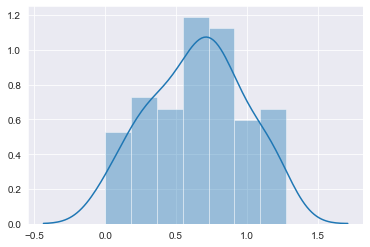

In [272]:
sns.distplot(e)
max(e)

In [276]:
trump_speeches.groupby(['state result'])['entropy'].median()

state result
blue state    0.317368
red state     0.443890
swing-blue    0.759808
swing-red     0.691348
Name: entropy, dtype: float64

In [278]:
trump_speeches.groupby(['city/county type'])['entropy'].median()

city/county type
blue    0.620996
red     0.673258
Name: entropy, dtype: float64

In [280]:
trump_speeches.groupby(['state result','city/county type'])['entropy'].median()

state result  city/county type
blue state    blue                0.396373
              red                 0.317368
red state     blue                0.383779
              red                 0.453975
swing-blue    blue                0.750721
              red                 0.805558
swing-red     blue                0.769012
              red                 0.651862
Name: entropy, dtype: float64

In [310]:
trump_speeches['main topic'] = doc_topic_matrix2.argmax(axis=1)

In [338]:
trump_speeches['secondary topic'] = doc_topic_matrix2.argsort()[:,-2]

In [311]:
trump_speeches['main topic'].value_counts()

3    27
1    22
2    17
0    13
4     4
Name: main topic, dtype: int64

In [341]:
trump_speeches.groupby(['state result','city/county type','main topic'])['main topic'].count()

state result  city/county type  main topic
blue state    blue              1              2
                                2              2
                                4              2
              red               1              2
                                2              1
red state     blue              1              3
                                3              1
              red               1              1
                                2              2
swing-blue    blue              0              1
                                1              6
                                2              6
                                3             10
                                4              1
              red               0              9
                                1              2
                                2              2
                                3              6
swing-red     blue              0              2
                          

In [313]:
trump_speeches.groupby(['city/county type','main topic'])['main topic'].count()

city/county type  main topic
blue              0              3
                  1             16
                  2             11
                  3             15
                  4              4
red               0             10
                  1              6
                  2              6
                  3             12
Name: main topic, dtype: int64

In [314]:
trump_speeches.groupby(['state result','main topic'])['main topic'].count()

state result  main topic
blue state    1              4
              2              3
              4              2
red state     1              4
              2              2
              3              1
swing-blue    0             10
              1              8
              2              8
              3             16
              4              1
swing-red     0              3
              1              6
              2              4
              3             10
              4              1
Name: main topic, dtype: int64

In [340]:
trump_speeches.groupby(['state result','city/county type','secondary topic'])['secondary topic'].count()

state result  city/county type  secondary topic
blue state    blue              0                  1
                                2                  2
                                3                  3
              red               0                  2
                                4                  1
red state     blue              0                  1
                                2                  1
                                3                  1
                                4                  1
              red               0                  1
                                1                  2
swing-blue    blue              0                  5
                                1                  2
                                2                  5
                                3                  4
                                4                  8
              red               0                  1
                                1                  

In [344]:
trump_speeches.groupby(['city/county type','secondary topic'])['secondary topic'].count()

city/county type  secondary topic
blue              0                   9
                  1                   6
                  2                  12
                  3                  10
                  4                  12
red               0                   6
                  1                   8
                  2                   7
                  3                   5
                  4                   8
Name: secondary topic, dtype: int64

In [346]:
trump_speeches.groupby(['state result','secondary topic'])['secondary topic'].count()

state result  secondary topic
blue state    0                   3
              2                   2
              3                   3
              4                   1
red state     0                   2
              1                   2
              2                   1
              3                   1
              4                   1
swing-blue    0                   6
              1                   4
              2                  11
              3                   9
              4                  13
swing-red     0                   4
              1                   8
              2                   5
              3                   2
              4                   5
Name: secondary topic, dtype: int64